## Setup

In [16]:
# change into the src directory
import git
import os

repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)

In [17]:
from tapas_gmm.policy.models.tpgmm import ModelType, TPGMM, ReconstructionStrategy, FittingStage, InitStrategy, _xdx_to_tangent, TPGMMConfig, AutoTPGMMConfig, AutoTPGMM, FrameSelectionConfig, DemoSegmentationConfig, CascadeConfig
# import lovely_tensors as lt
# lt.monkey_patch()
from lovely_numpy import lo
import matplotlib.pyplot as plt

import pathlib
#from pbdlib.utils.jupyter_utils import *
import numpy as np

from conf._machine import data_naming_config as machine_data_naming_config
from tapas_gmm.dataset.demos import Demos, PartialFrameViewDemos
import tapas_gmm.policy.models.tpgmm
from tapas_gmm.utils.misc import load_scene_data, DataNamingConfig
from tapas_gmm.utils.logging import setup_logger  # noqa: F401
from tapas_gmm.viz.gmm import plot_log_map_quaternions, plot_hmm_transition_matrix

%matplotlib inline

%load_ext autoreload
%autoreload 2

data_root = pathlib.Path(machine_data_naming_config.data_root).resolve()
data_root = data_root.parent / data_root.stem

np.set_printoptions(precision=2)

plt.style.use('default')

from IPython.display import HTML
from matplotlib import rc
rc('animation', html='jshtml')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
task = "BlockMoveTo"
path = data_root / task / "demos"

data_config = DataNamingConfig(
    feedback_type=None,
    task=None,
    data_root=None,
    path=path,
)

scene_data = load_scene_data(data_config)
print(scene_data.sample_data_point_with_ground_truth(cam="wrist"))

SingleCamSceneObservation(
    action=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    depth=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
    ee_pose=Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
    extr=Tensor(shape=torch.Size([4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
    feedback=Tensor(shape=torch.Size([1]), device=cpu, dtype=torch.float32, is_shared=False),
    intr=Tensor(shape=torch.Size([3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
    mask=Tensor(shape=torch.Size([256, 256]), device=cpu, dtype=torch.uint8, is_shared=False),
    object_poses=TensorDict(
        fields={
            obj000: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj001: Tensor(shape=torch.Size([7]), device=cpu, dtype=torch.float32, is_shared=False),
            obj002: Tensor(shape=torch.Size([7]), device=cpu, dtype

In [19]:
gt_pose_config = {}

gt_kp_config = {
    'encoder_name': 'demos_keypoints_gt_encoder-world',
    'cam': 'static',
}

kp_config = {
    'encoder_name': 'demos_vit_keypoints_encoder',
    'encoding_name': 'gtcopy',
}


In [20]:
observations = scene_data.get_demos(**gt_pose_config)
print(observations[0].keys())
print(observations[0])
n_obs = len(observations)

demo_meta_data = {
    'path': path
}

data_kwargs = dict(
    meta_data=demo_meta_data,
    add_init_ee_pose_as_frame=True,
    add_world_frame=False,
    frames_from_keypoints=False,
    kp_indeces=None,
    enforce_z_up=False,
    modulo_object_z_rotation=False,
    make_quats_continuous=True
)

demos = Demos(observations, **data_kwargs)
print(demos)

_LazyStackedTensorDictKeysView(['action', 'cameras', 'ee_pose', 'feedback', 'gripper_state', 'joint_pos', 'joint_vel', 'object_poses', 'object_states'],
    include_nested=False,
    leaves_only=False)
SceneObservation(
    action=Tensor(shape=torch.Size([51, 7]), device=cpu, dtype=torch.float32, is_shared=False),
    cameras=LazyStackedTensorDict(
        fields={
            _order: CameraOrder(
                order=('wrist',),
                batch_size=torch.Size([51]),
                device=None,
                is_shared=False),
            wrist: SingleCamObservation(
                depth=Tensor(shape=torch.Size([51, 256, 256]), device=cpu, dtype=torch.float32, is_shared=False),
                extr=Tensor(shape=torch.Size([51, 4, 4]), device=cpu, dtype=torch.float32, is_shared=False),
                intr=Tensor(shape=torch.Size([51, 3, 3]), device=cpu, dtype=torch.float32, is_shared=False),
                rgb=Tensor(shape=torch.Size([51, 3, 256, 256]), device=cpu, dtype=to

In [21]:
tpgmm_config = TPGMMConfig(
    n_components=10,
    model_type=ModelType.HMM,
    use_riemann=True,
    add_time_component=True,
    add_action_component=False,
    position_only=False,
    add_gripper_action=False,
    reg_shrink=1e-2,
    reg_diag=2e-4,
    reg_diag_gripper=2e-2,
    reg_em_finish_shrink=1e-2,
    reg_em_finish_diag=2e-4,
    reg_em_finish_diag_gripper=2e-2,
    trans_cov_mask_t_pos_corr=False,
    em_steps=50,
    fix_first_component=True,
    fix_last_component=True,
    reg_init_diag=5e-4,  # 5
    heal_time_variance=False,
)

frame_selection_config = FrameSelectionConfig(
    init_strategy=InitStrategy.TIME_BASED,
    fitting_actions=(FittingStage.INIT,),
    rel_score_threshold=0.5,
    use_bic=False,
    drop_redundant_frames=False,
)

demos_segmentation_config = DemoSegmentationConfig(
    gripper_based=False,
    distance_based=False,
    velocity_based=True,
    repeat_final_step=0,
    repeat_first_step=0,
    components_prop_to_len=True,
    min_n_components=1,
    velocity_threshold=0.001,
)

cascade_config = CascadeConfig(
    kl_keep_time_dim=True,
    kl_keep_rotation_dim=False,
)

auto_tpgmm_config = AutoTPGMMConfig(
    tpgmm=tpgmm_config,
    frame_selection=frame_selection_config,
    demos_segmentation=demos_segmentation_config,
    cascade=cascade_config,
)

In [22]:
atpgmm = AutoTPGMM(auto_tpgmm_config)


2025-08-05 03:58:19.477 | INFO     |  Fitting AutoTPGMM
2025-08-05 03:58:19.477 | INFO     |  Segmenting trajectories


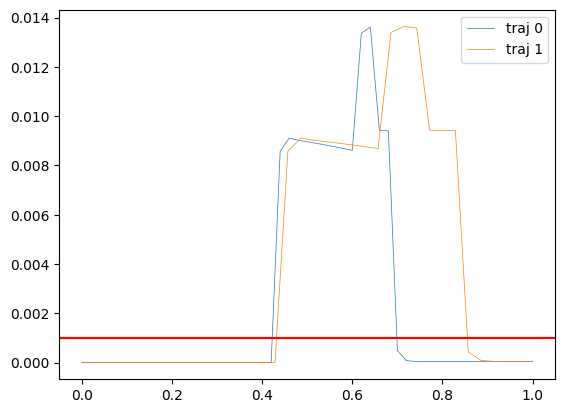

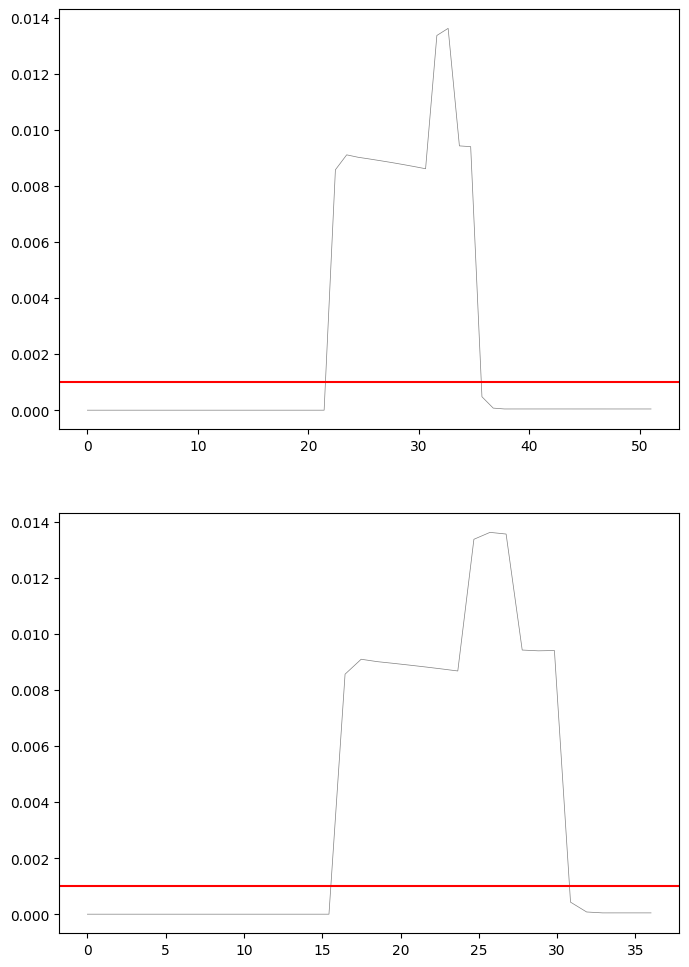

2025-08-05 03:58:21.085 | INFO     |  Creating segement of demos.
2025-08-05 03:58:21.089 | INFO     |  ... created 1 segments
2025-08-05 03:58:21.089 | INFO     |    Fitting candidate frame 1/10
2025-08-05 03:58:21.089 | INFO     |    Creating partial frame view of demos.
2025-08-05 03:58:21.091 | INFO     |    Manifold: TIME x R3 x QUAT


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-05 03:58:21.515 | INFO     |    Fitting candidate frame 2/10
2025-08-05 03:58:21.516 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-05 03:58:21.878 | INFO     |    Fitting candidate frame 3/10
2025-08-05 03:58:21.879 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-05 03:58:22.220 | INFO     |    Fitting candidate frame 4/10
2025-08-05 03:58:22.220 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-05 03:58:22.586 | INFO     |    Fitting candidate frame 5/10
2025-08-05 03:58:22.588 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-05 03:58:22.959 | INFO     |    Fitting candidate frame 6/10
2025-08-05 03:58:22.960 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-05 03:58:23.266 | INFO     |    Fitting candidate frame 7/10
2025-08-05 03:58:23.267 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-05 03:58:23.631 | INFO     |    Fitting candidate frame 8/10
2025-08-05 03:58:23.632 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-05 03:58:23.891 | INFO     |    Fitting candidate frame 9/10
2025-08-05 03:58:23.892 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-05 03:58:24.114 | INFO     |    Fitting candidate frame 10/10
2025-08-05 03:58:24.115 | INFO     |    Creating partial frame view of demos.


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

2025-08-05 03:58:24.383 | INFO     |  Creating partial frame view of demos.
2025-08-05 03:58:24.433 | INFO     |  Segmented trajs into 1 segments
2025-08-05 03:58:24.467 | INFO     |  Frame score (abs):
            ee_init    obj000    obj001    obj002    obj003    obj004  \
Segment 0 -0.140697 -0.140697 -0.140697 -0.140697 -0.140697 -0.140697   

             obj005    obj006   obj007    obj008  
Segment 0 -0.140697 -0.007324 -0.01355 -0.005193  
2025-08-05 03:58:24.480 | INFO     |  Frame score (rel):
           ee_init  obj000  obj001  obj002  obj003  obj004  obj005    obj006  \
Segment 0      1.0     1.0     1.0     1.0     1.0     1.0     1.0  0.052059   

             obj007    obj008  
Segment 0  0.096308  0.036907  


Fitting segments:   0%|          | 0/1 [00:00<?, ?it/s]

2025-08-05 03:58:24.525 | INFO     |  Manifold: TIME x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT x R3 x QUAT


Time-based init:   0%|          | 0/10 [00:00<?, ?it/s]

((array([[5.09e+052, 5.09e+052, 2.07e+052, 3.43e+051, 2.31e+050, 6.32e+048,
          7.05e+046, 3.19e+044, 5.89e+041, 4.42e+038, 1.35e+035, 1.67e+031,
          8.45e+026, 1.74e+022, 1.45e+017, 4.93e+011, 6.83e+005, 3.84e-001,
          8.79e-008, 4.91e-015, 3.50e-023, 3.27e-032, 4.12e-042, 7.11e-053,
          1.45e-067, 1.89e-080, 3.78e-094, 1.12e-109, 1.07e-126, 2.07e-142,
          1.07e-153, 2.30e-165, 1.92e-177, 6.53e-190, 9.03e-203, 5.45e-216,
          1.25e-229, 1.16e-243, 4.39e-258, 6.77e-273, 4.55e-288, 1.16e-303,
          1.20e-319, 5.09e+052, 5.09e+052, 2.07e+052, 3.43e+051, 2.31e+050,
          6.32e+048, 7.05e+046, 3.19e+044, 5.89e+041, 4.42e+038, 1.35e+035,
          1.67e+031, 8.45e+026, 1.74e+022, 1.45e+017, 4.93e+011, 6.83e+005,
          3.84e-001, 8.79e-008, 8.19e-015, 1.86e-022, 5.38e-031, 3.37e-039,
          5.22e-049, 1.08e-059, 3.10e-071, 1.25e-083, 8.72e-094, 2.08e-107,
          7.38e-122, 4.70e-138, 9.52e-156, 6.52e-175, 3.55e-190, 4.58e-203,
          2.

In [23]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       init_strategy=InitStrategy.TIME_BASED,
                       fitting_actions=(FittingStage.INIT,)) # FittingStage.EM_HMM))


2025-08-05 03:58:26.434 | INFO     |  Did not specify time_based, deciding automatically.


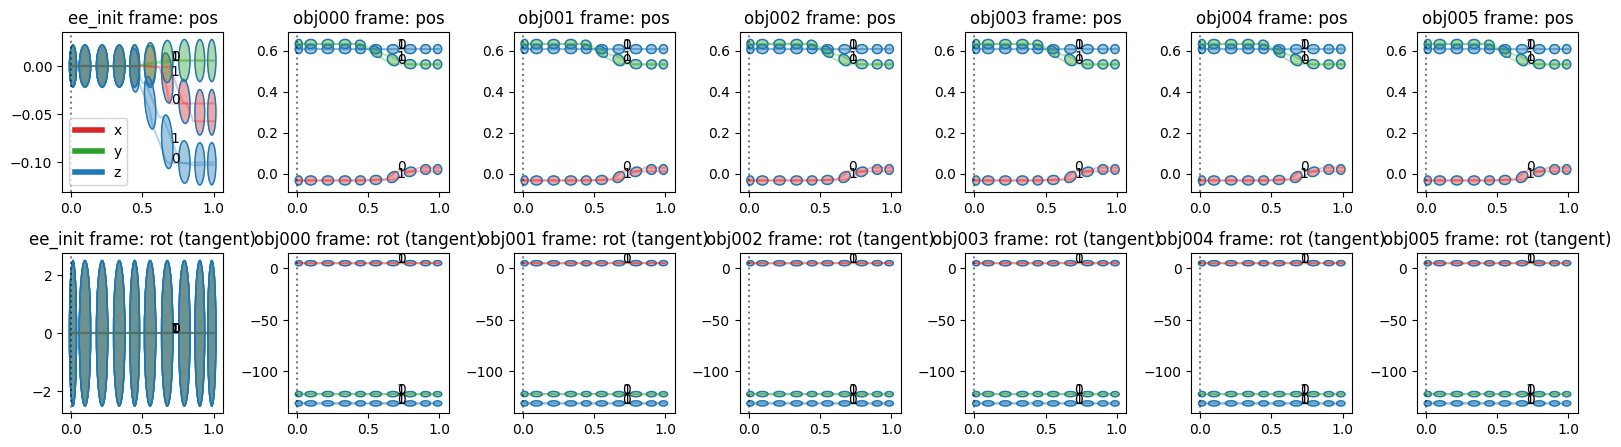

In [24]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=False, annotate_trajs=True,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False) #, size=(150, 10))


In [25]:
atpgmm.fit_trajectories(demos, fix_frames=True,
                       fitting_actions=(FittingStage.EM_HMM, ))


2025-08-05 03:58:34.453 | INFO     |  Fitting AutoTPGMM


Fitting segments:   0%|          | 0/1 [00:00<?, ?it/s]

HMM EM:   0%|          | 0/50 [00:00<?, ?it/s]

((array([[1.28e-027, 1.88e-035, 8.14e-044, 5.25e-053, 2.43e-063, 2.75e-075,
          2.12e-089, 4.31e-106, 1.15e-125, 1.77e-148, 4.69e-175, 6.85e-206,
          2.54e-241, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 1.28e-027, 1.88e-035, 8.14e-044, 5.25e-053, 2.43e-063,
          2.75e-075, 2.12e-089, 4.31e-106, 1.15e-125, 1.77e-148, 4.69e-175,
          6.85e-206, 2.54e-241, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000, 0.00e+000,
          0.

2025-08-05 03:58:46.641 | INFO     |  Did not specify time_based, deciding automatically.


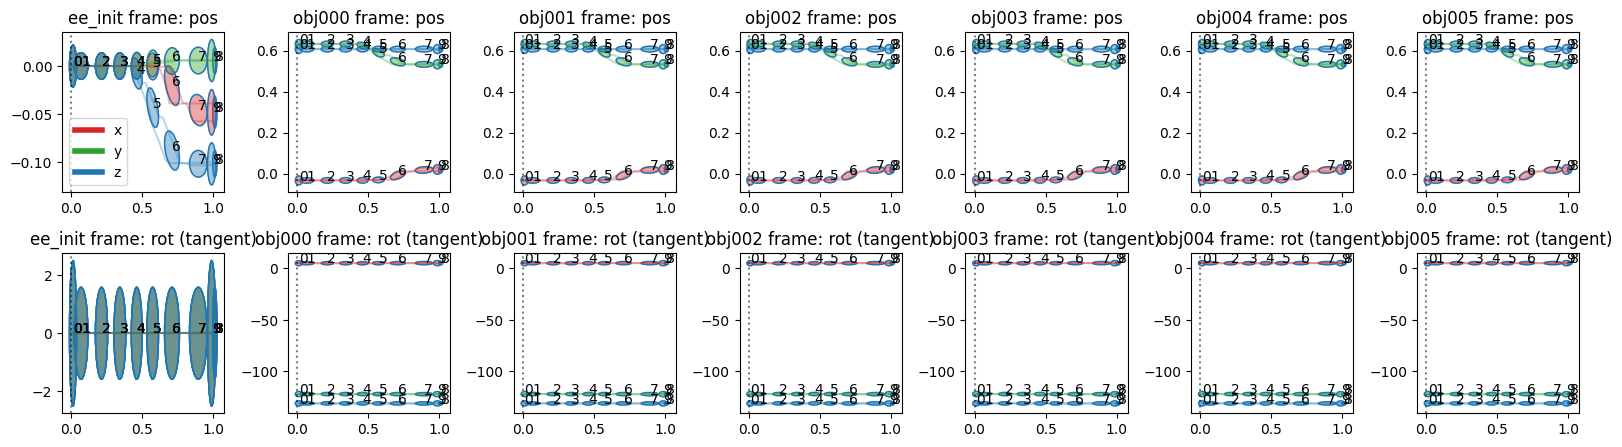

In [26]:

atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=True,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False)

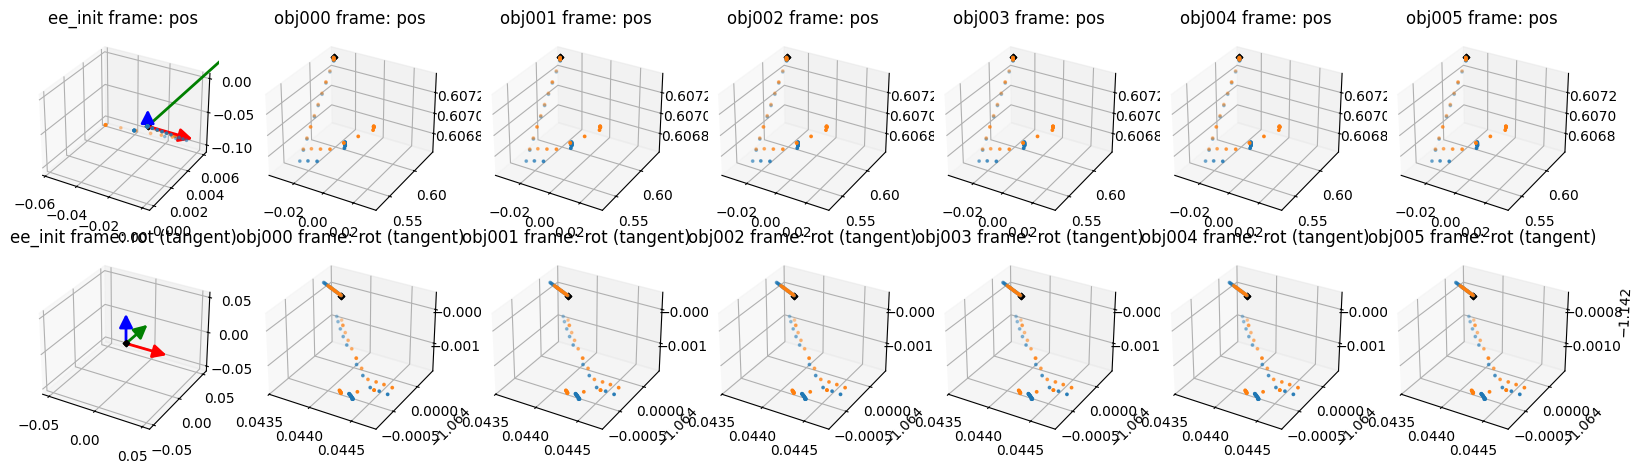

In [27]:
atpgmm.plot_model(
    scatter=True, rotations_raw=True, plot_traj=True, plot_gaussians=False,
    annotate_gaussians=True, annotate_trajs=False,
    mean_as_base=False, per_segment=False, gaussian_mean_only=False, plot_traj_means=False, time_based=False)

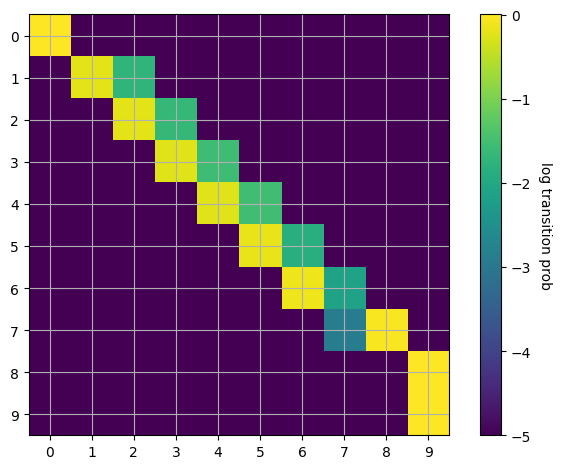

In [28]:
atpgmm.plot_hmm_transition_matrix()

In [29]:
atpgmm.to_disk(data_root / task / 'demos_gmm_policy-release.pt')

In [30]:
seg_local_marginals, seg_trans_marginals, seg_trans_marg_container, seg_joint_models, cascaded_hmms, (reconstructions, original_trajectories, extras) = atpgmm.reconstruct(
    strategy=tapas_gmm.policy.models.tpgmm.ReconstructionStrategy.GMR,
    use_ss=False)


Transforming marginals:   0%|          | 0/2 [00:00<?, ?it/s]

Joining marginals:   0%|          | 0/2 [00:00<?, ?it/s]

GMR:   0%|          | 0/2 [00:00<?, ?it/s]

ValueError: not enough values to unpack (expected 6, got 4)

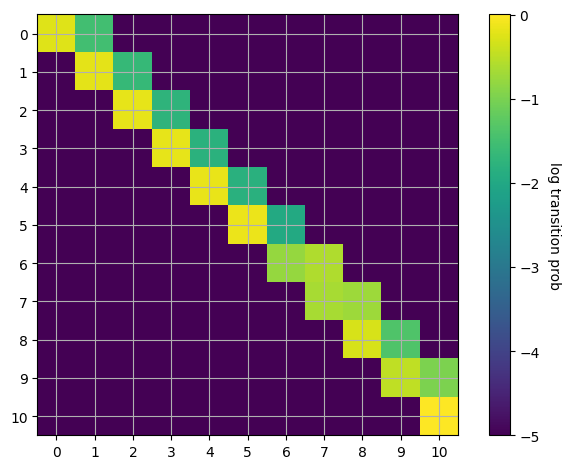

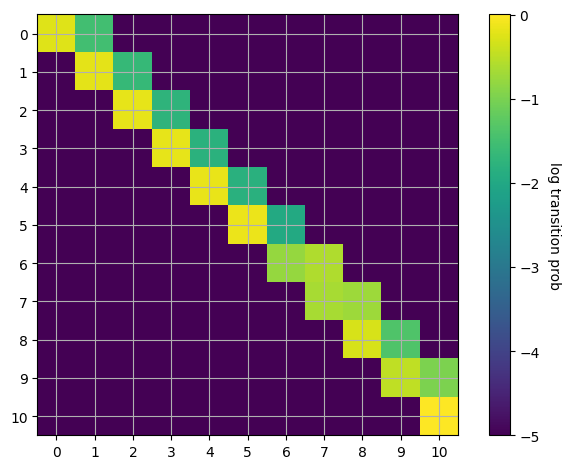

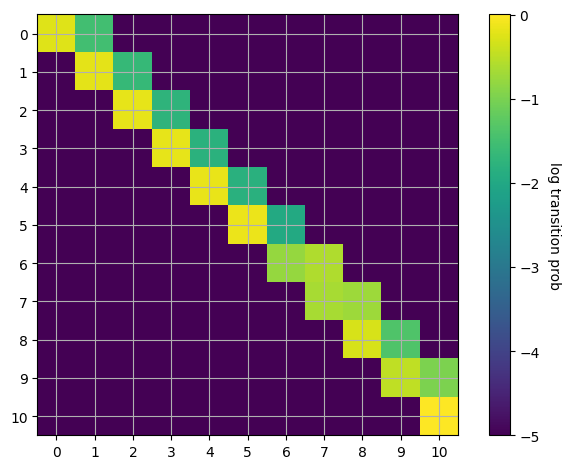

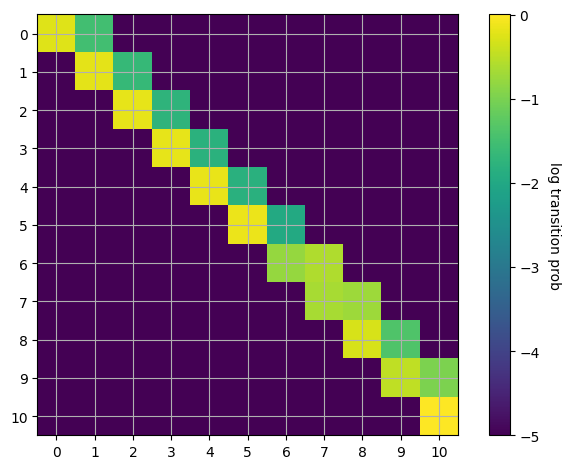

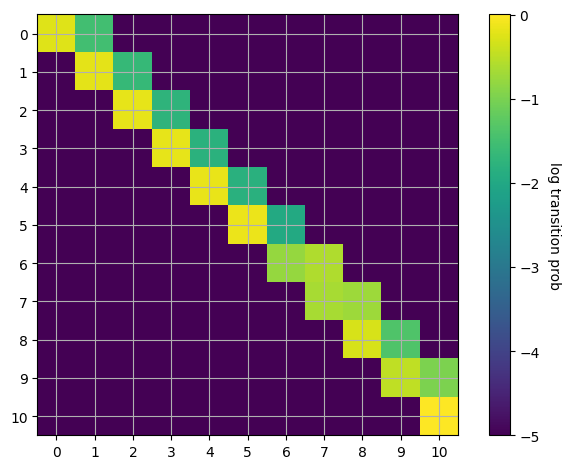

In [ ]:
for cascaded_hmm in cascaded_hmms:
    plot_hmm_transition_matrix(cascaded_hmm)

2025-02-09 02:35:54.076 | INFO     |  Taking frame origins from demos.


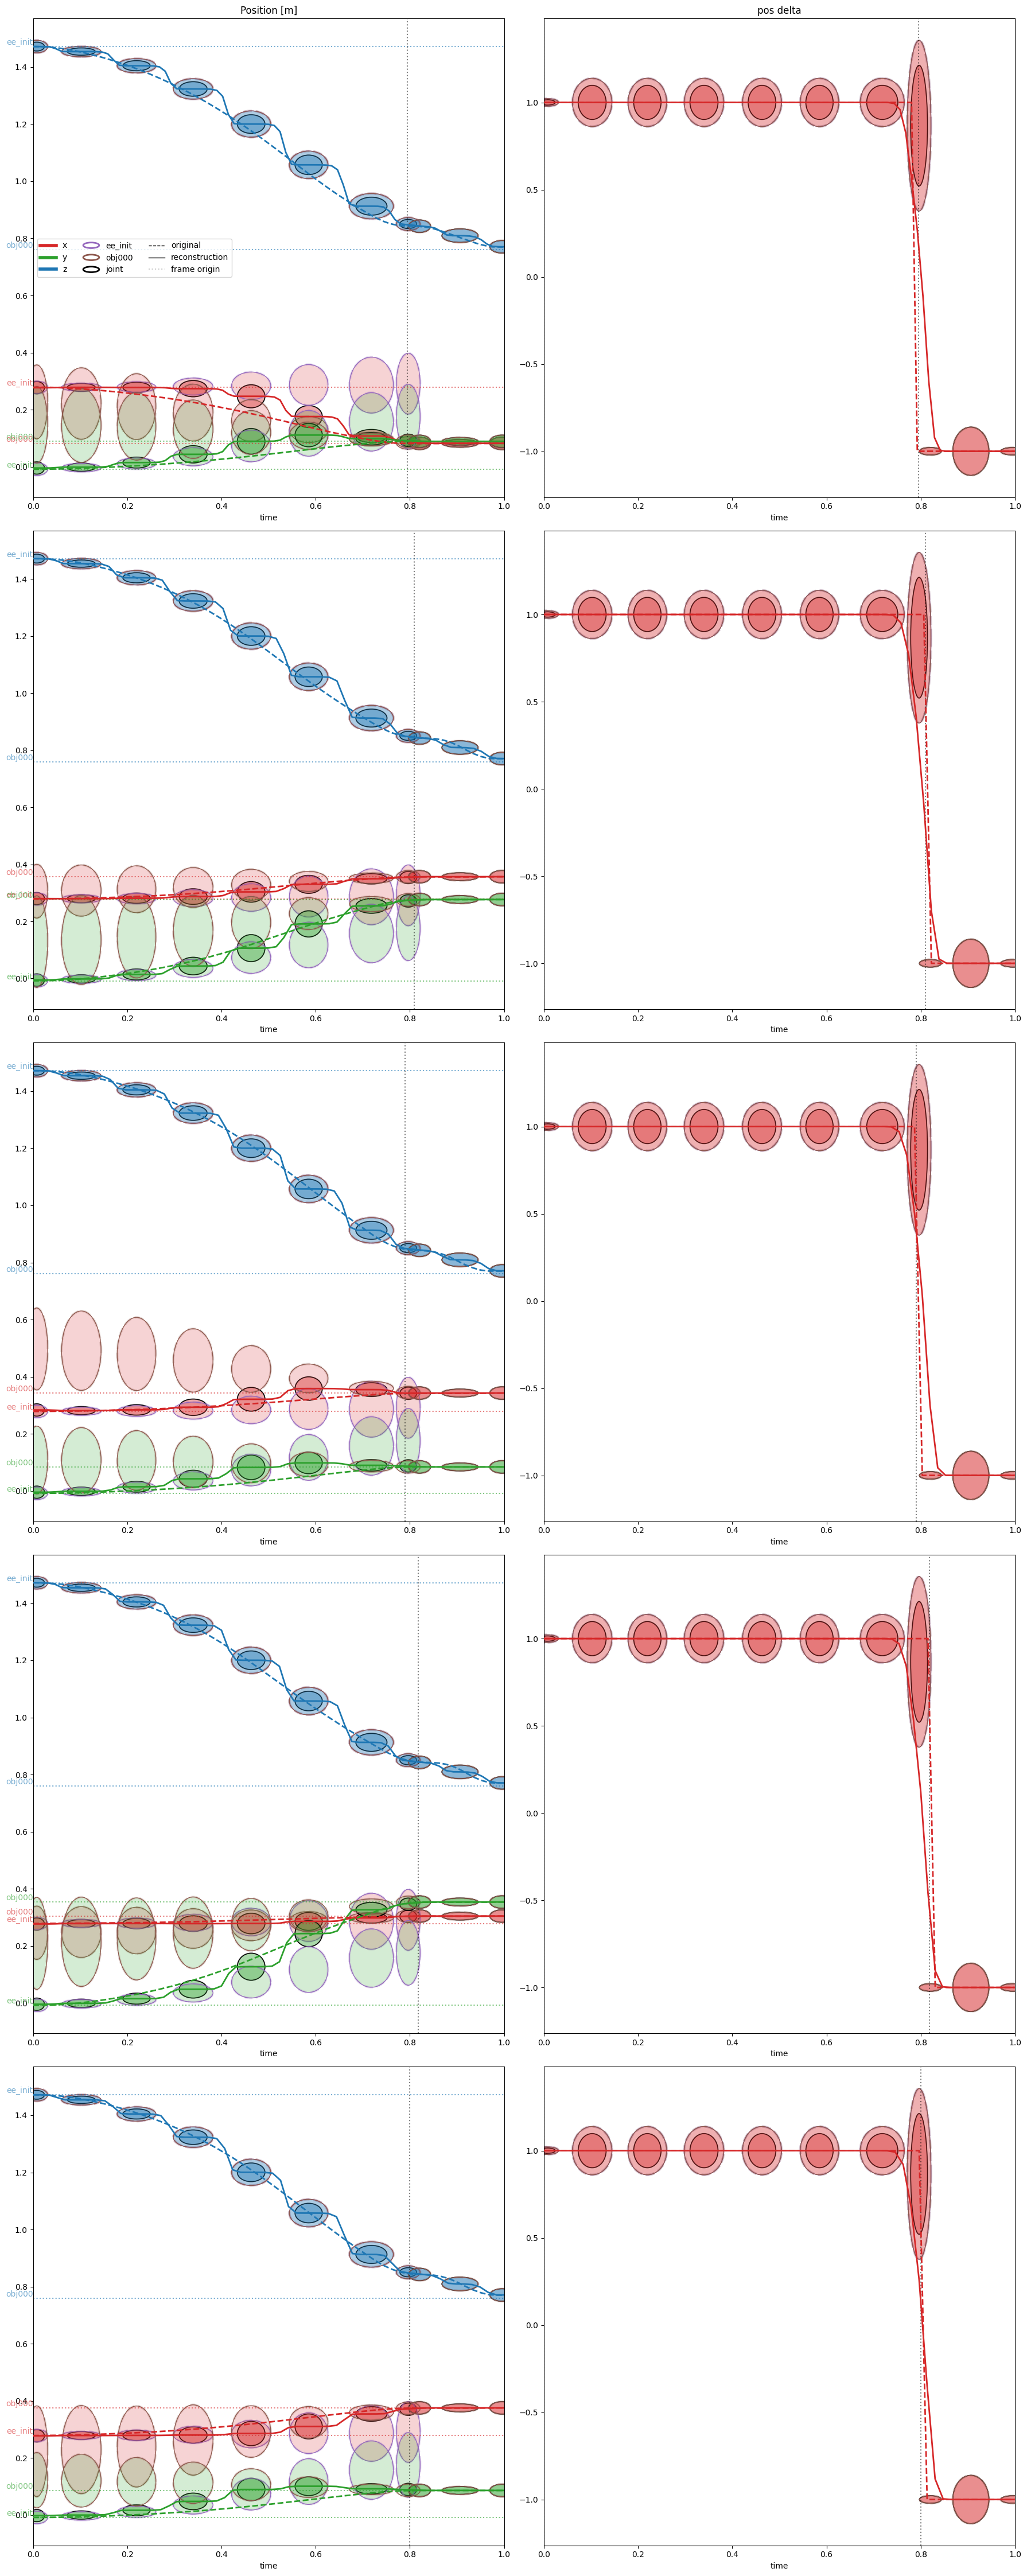

In [ ]:

atpgmm.plot_reconstructions(
    seg_trans_marg_container, cascaded_hmms, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=True, equal_aspect=False, per_segment=False)


2025-02-09 02:36:23.410 | WARNING  |  Model uses moving frames. Can only plot one at a time. Plotting the one from the first time step.


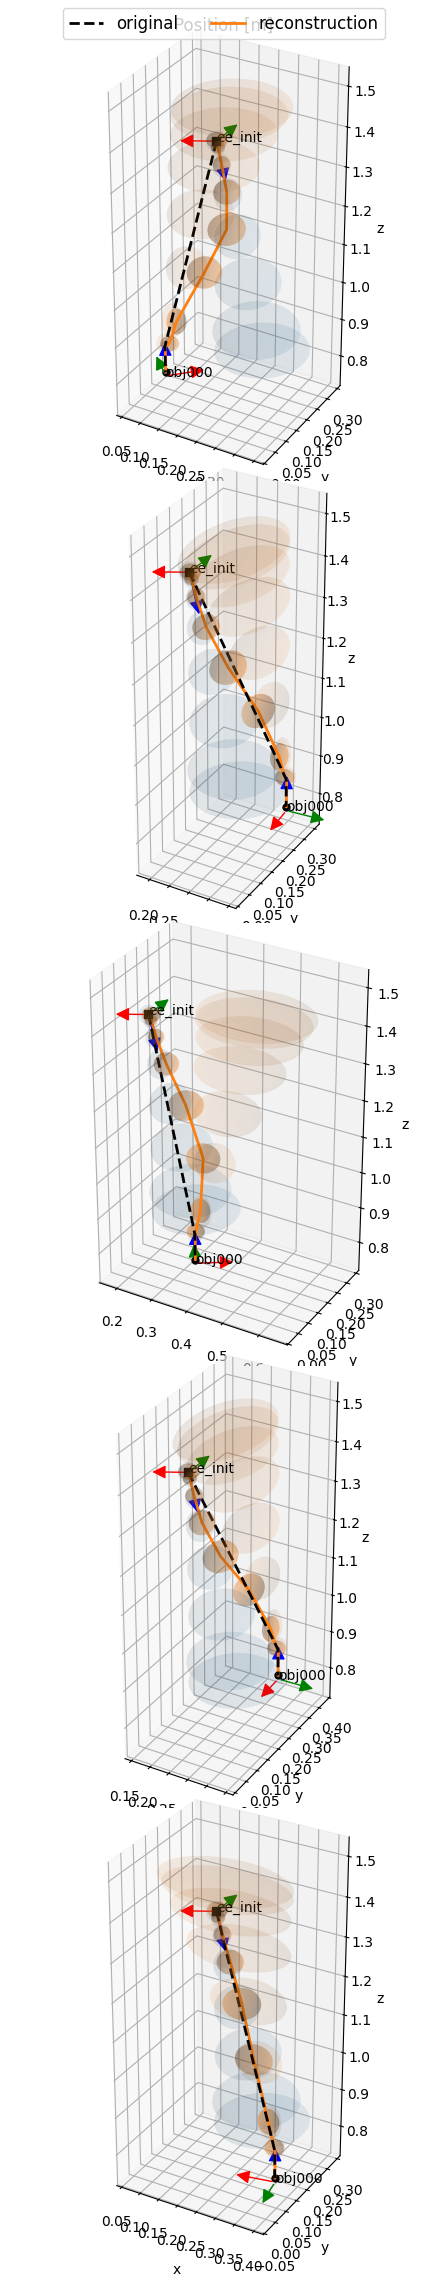

In [ ]:
atpgmm.plot_reconstructions(
    seg_trans_marginals, seg_joint_models, reconstructions, original_trajectories,
    plot_trajectories=True, plot_reconstructions=True, plot_gaussians=True,
    time_based=False, equal_aspect=True, per_segment=False)
